In [1]:
import xarray as xr

import glob
import os
import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd

from dask.distributed import Client, LocalCluster

## Open Cloud Height xarray dataset

In [2]:
zarr_path = '/storage/GOES/orthorectified/Fog2022_withtime.zarr'
ds = xr.open_dataset(
    zarr_path,
    chunks={'time': 40785, 'latitude': 50, 'longitude': 50},
    engine='zarr'
)
# When we pass in a chunks argument, the dataset opened will be filled with Dask arrays

/home/ngoc54n/miniconda3/envs/goesenv/lib/python3.11/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "latitude" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/ngoc54n/miniconda3/envs/goesenv/lib/python3.11/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "longitude" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [3]:
# Longitudes and Latitudes for all the field locations on San Juan Islands
mtdallas = (48.53, -123.13)
cattlepoint = (48.46, -122.96)
falsebay = (48.48, -123.06)
fhl = (48.55, -123.01)

In [4]:
falsebay_timeseries = ds['Height'].sel(latitude = falsebay[0], longitude = falsebay[1], method='nearest')
falsebay_timeseries

<xarray.DataArray 'Height' (time: 40785)>
dask.array<getitem, shape=(40785,), dtype=float32, chunksize=(40785,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float64 48.48
    longitude  float64 -123.1
  * time       (time) datetime64[ns] 2022-04-30T17:01:17 ... 2022-09-30T16:51:17
Attributes:
    coordinates:   dem_px_angle_y dem_px_angle_x
    grid_mapping:  spatial_ref

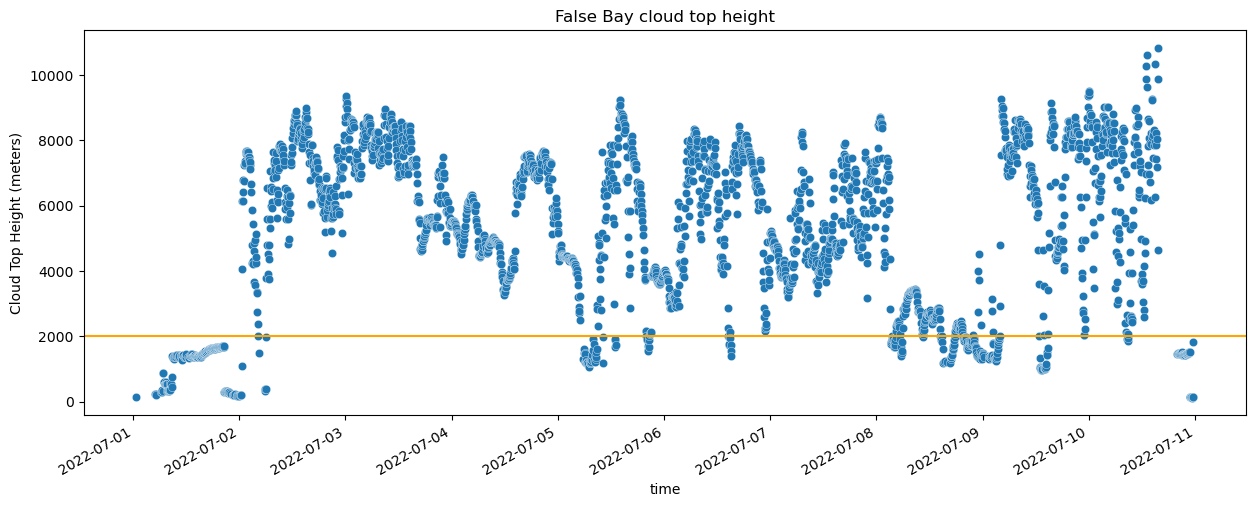

In [5]:
falsebay_timeseries.sel(time = slice('July 1, 2022', 'July 10, 2022')).plot.scatter('time', figsize=(15,5), linewidths=0.25)
plt.title('False Bay cloud top height')
plt.ylabel('Cloud Top Height (meters)')
plt.axhline(2000, color='orange') # 2000 meters is the chosen threshold for low cloud and fog

## Open computer vision fog prediction pandas dataframe

In [79]:
df = pd.read_csv('FalseBay_predicted_time_df.csv', index_col = 0)

In [80]:
df.shape[0]

2192

In [81]:
# Convert the time values which are currently strings to datetime
df['Time'] = pd.to_datetime(df['Time'])
type(df.index[0])

numpy.int64

In [82]:
time_df = df.set_index('Time') # can only slice time if time is index

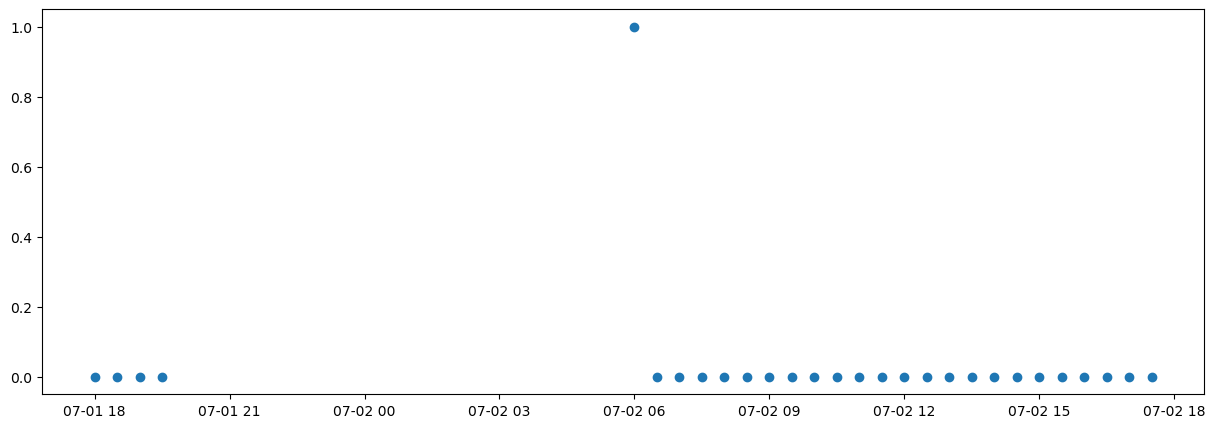

In [101]:
plt.figure(figsize=(15,5))
plt.scatter(time_df['2022-07-01 18:00:00': '2022-07-02 18:00:00'].index, time_df['2022-07-01 18:00:00': '2022-07-02 18:00:00']["Predicted label"])
# plt.scatter(time_df[10:30].index, time_df[10:30]["Predicted label"])

## Compare

In [ ]:
# Merge the Cloud Height DataArray and Fog Dataframe into one dataframe with the same time column/index
# Convert Cloud Height into pandas dataframe
height_df = falsebay_timeseries.to_dataframe()
height_df

In [12]:
# height_df.to_csv('falsebay_cloudheight_df.csv')

In [122]:
result = pd.concat([height_df, time_df], axis=1)

In [124]:
result[100:125]

,latitude,longitude,Height,Predicted label
2022-05-01 07:06:17,48.476114,-123.056412,1186.326782,NaN
2022-05-01 07:11:17,48.476114,-123.056412,1163.131348,NaN
2022-05-01 07:16:17,48.476114,-123.056412,1225.087646,NaN
2022-05-01 07:21:17,48.476114,-123.056412,1185.105957,NaN
2022-05-01 07:26:17,48.476114,-123.056412,1056.310059,NaN
2022-05-01 07:30:01,NaN,NaN,NaN,1.0
2022-05-01 07:31:17,48.476114,-123.056412,907.370605,NaN
2022-05-01 07:36:17,48.476114,-123.056412,842.667419,NaN
2022-05-01 07:41:17,48.476114,-123.056412,850.907959,NaN
2022-05-01 07:46:17,48.476114,-123.056412,755.073975,NaN


In [133]:
result = result.reset_index()
result

,index,latitude,longitude,Height,Predicted label
0,2022-04-30 17:01:17,48.476114,-123.056412,770.639343,NaN
1,2022-04-30 17:06:17,48.476114,-123.056412,698.916504,NaN
2,2022-04-30 17:11:17,48.476114,-123.056412,NaN,NaN
3,2022-04-30 17:16:17,48.476114,-123.056412,NaN,NaN
4,2022-04-30 17:21:17,48.476114,-123.056412,NaN,NaN
...,...,...,...,...,...
42972,2022-09-30 16:31:17,48.476114,-123.056412,1886.464111,NaN
42973,2022-09-30 16:36:17,48.476114,-123.056412,1928.582275,NaN
42974,2022-09-30 16:41:17,48.476114,-123.056412,NaN,NaN
42975,2022-09-30 16:46:17,48.476114,-123.056412,2023.500610,NaN


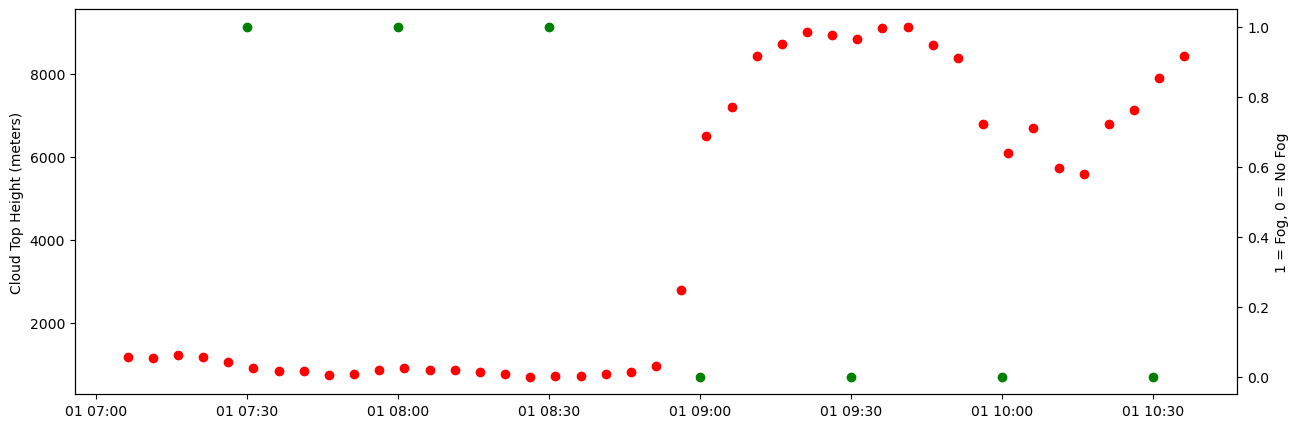

In [143]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax_twin = ax1.twinx()
ax1.set_ylabel("Cloud Top Height (meters)")
ax_twin.set_ylabel("1 = Fog, 0 = No Fog")

df1 = result[100:150]
ax1.scatter(df1["index"], df1["Height"], color = 'r')
ax_twin.scatter(df1["index"], df1["Predicted label"], color = 'g')

# awesome job Autumn! now try Cassie's way to plot the fog/no fog as background vertical lines!

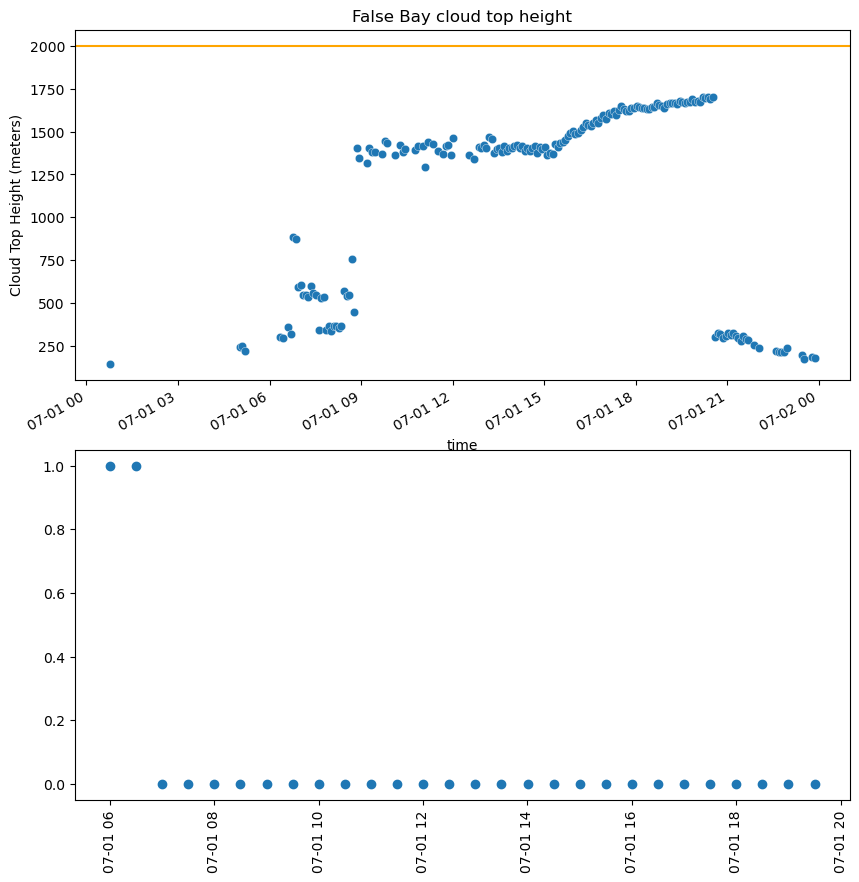

In [84]:
# Old code
fig, ax = plt.subplots(ncols=1, nrows=2, figsize = (10, 10))

falsebay_timeseries.sel(time = slice('July 1, 2022', 'July 1, 2022')).plot.scatter('time', linewidths=0.25, ax = ax[0])
ax[0].set_title('False Bay cloud top height')
ax[0].set_ylabel('Cloud Top Height (meters)')
ax[0].axhline(2000, color='orange') # 2000 meters is the chosen threshold for low cloud and fog

test_df = time_df['2022-07-01': '2022-07-01']
# fig.autofmt_xdate()
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].locator_params(axis='x', nbins=10)
ax[1].scatter(test_df.index, test_df['Predicted label'])